
=== TRAIN DATA EDA ===

=== TRAIN DATA EXPLORATION ===
Shape: (10886, 23)

Missing Values:
datetime          0
season            0
holiday           0
workingday        0
weather           0
temp              0
atemp             0
humidity          0
windspeed         0
casual            0
registered        0
count             0
hour              0
day               0
month             0
year              0
dayofweek         0
weekend           0
hour_sin          0
hour_cos          0
temp_humidity     0
temp_windspeed    0
temp_bin          0
dtype: int64

Target Variable (count) Statistics:
count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64


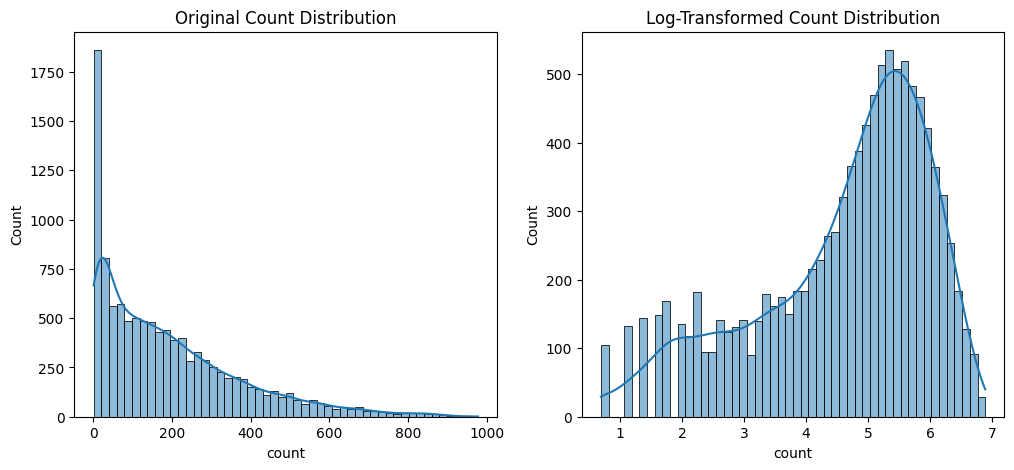

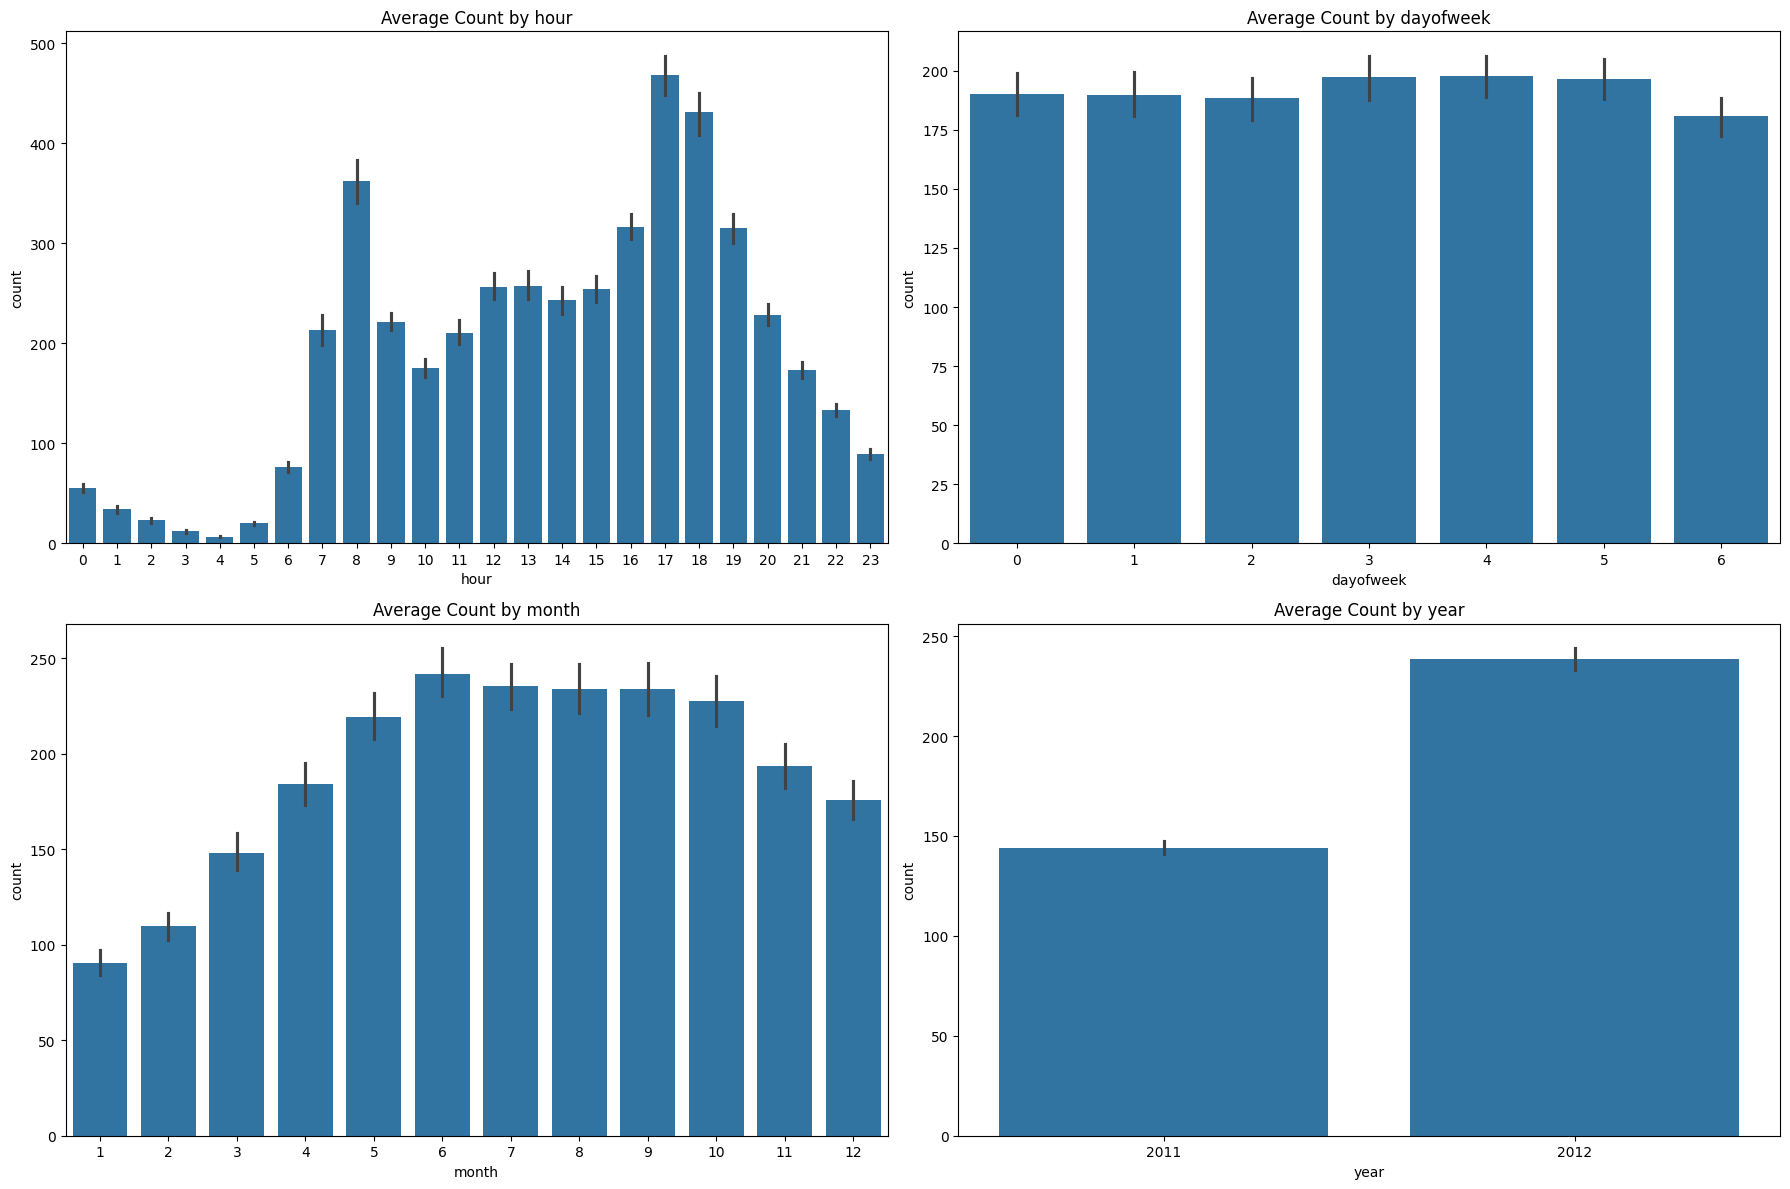

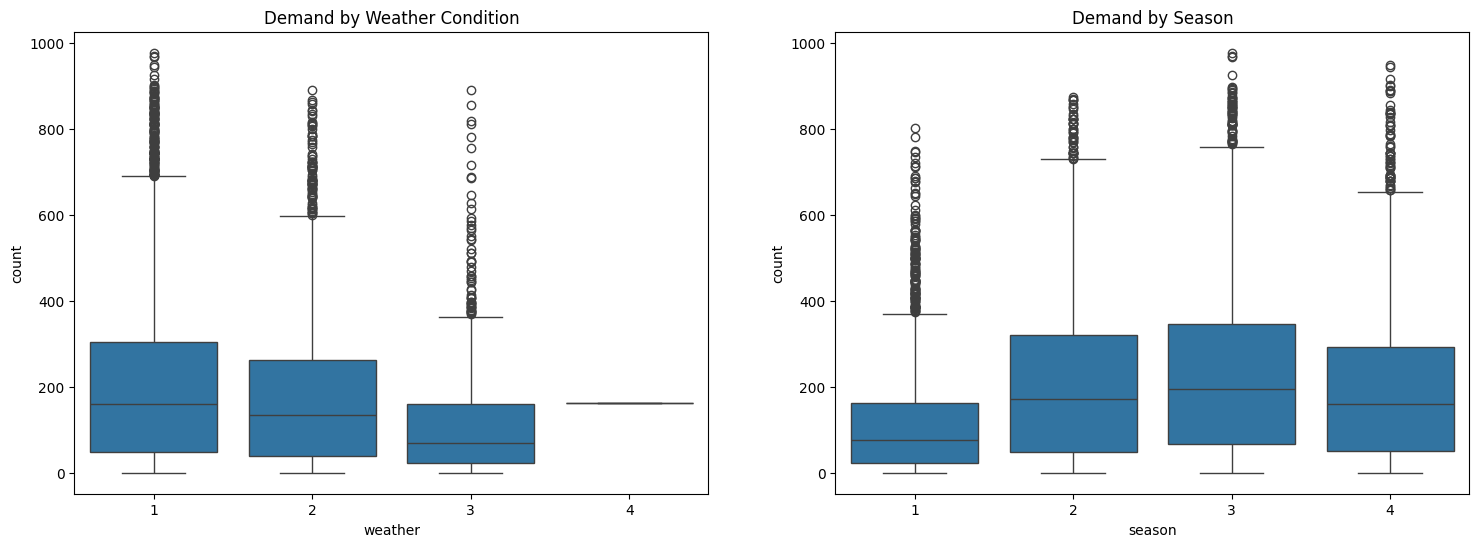

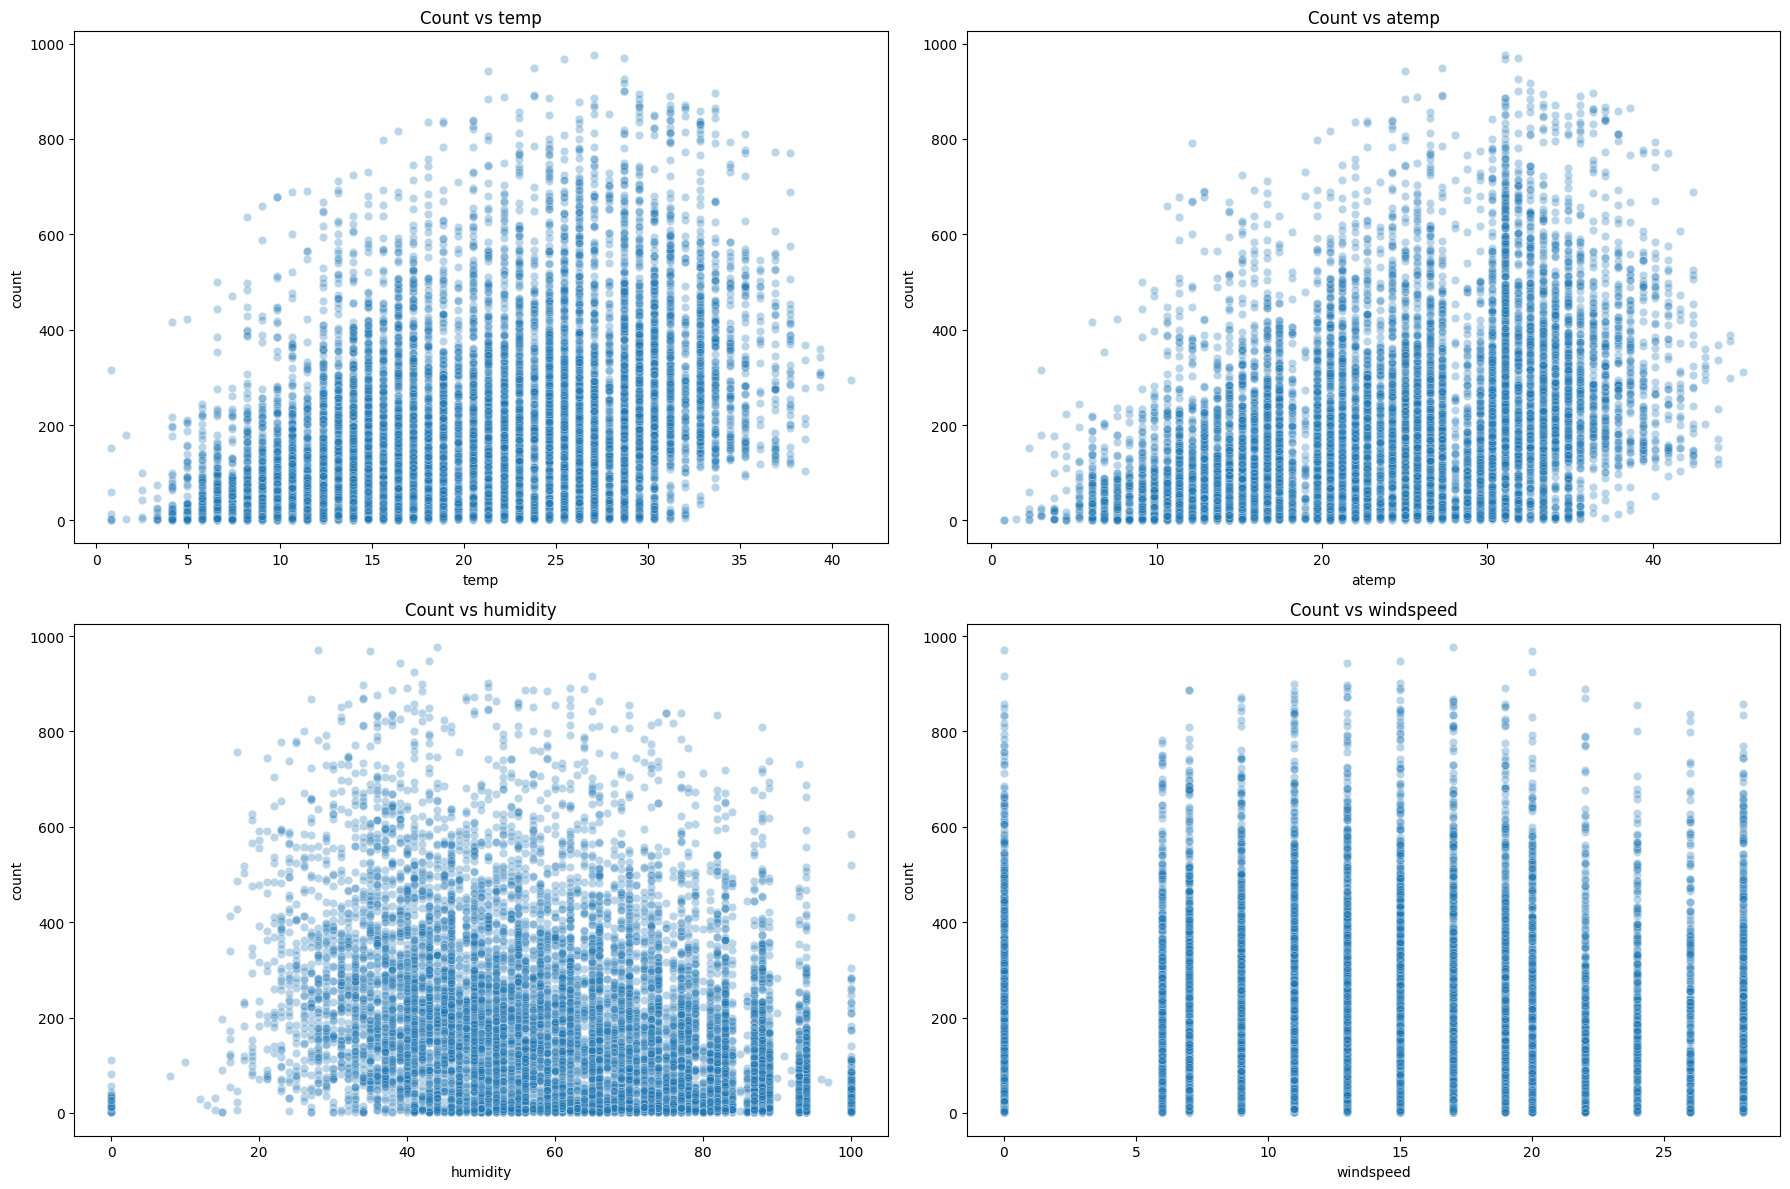

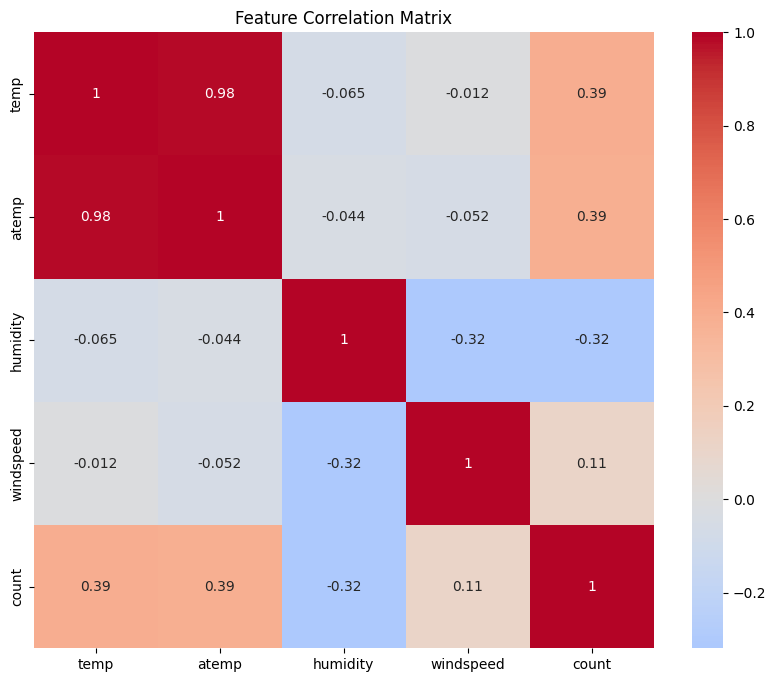


=== TEST DATA EDA ===

=== TEST DATA EXPLORATION ===
Shape: (6493, 20)

Missing Values:
datetime          0
season            0
holiday           0
workingday        0
weather           0
temp              0
atemp             0
humidity          0
windspeed         0
hour              0
day               0
month             0
year              0
dayofweek         0
weekend           0
hour_sin          0
hour_cos          0
temp_humidity     0
temp_windspeed    0
temp_bin          0
dtype: int64

Linear Regression Performance:
RMSE: 133.58
MAE: 85.53
R2 Score: 0.4594

Ridge Regression Performance:
RMSE: 133.57
MAE: 85.53
R2 Score: 0.4595

Lasso Regression Performance:
RMSE: 142.87
MAE: 90.41
R2 Score: 0.3816

Decision Tree Performance:
RMSE: 110.95
MAE: 69.84
R2 Score: 0.6270

Random Forest Performance:
RMSE: 40.51
MAE: 24.47
R2 Score: 0.9503

Gradient Boosting Performance:
RMSE: 68.93
MAE: 42.95
R2 Score: 0.8560

XGBoost Performance:
RMSE: 41.53
MAE: 25.35
R2 Score: 0.9478
[LightGBM]

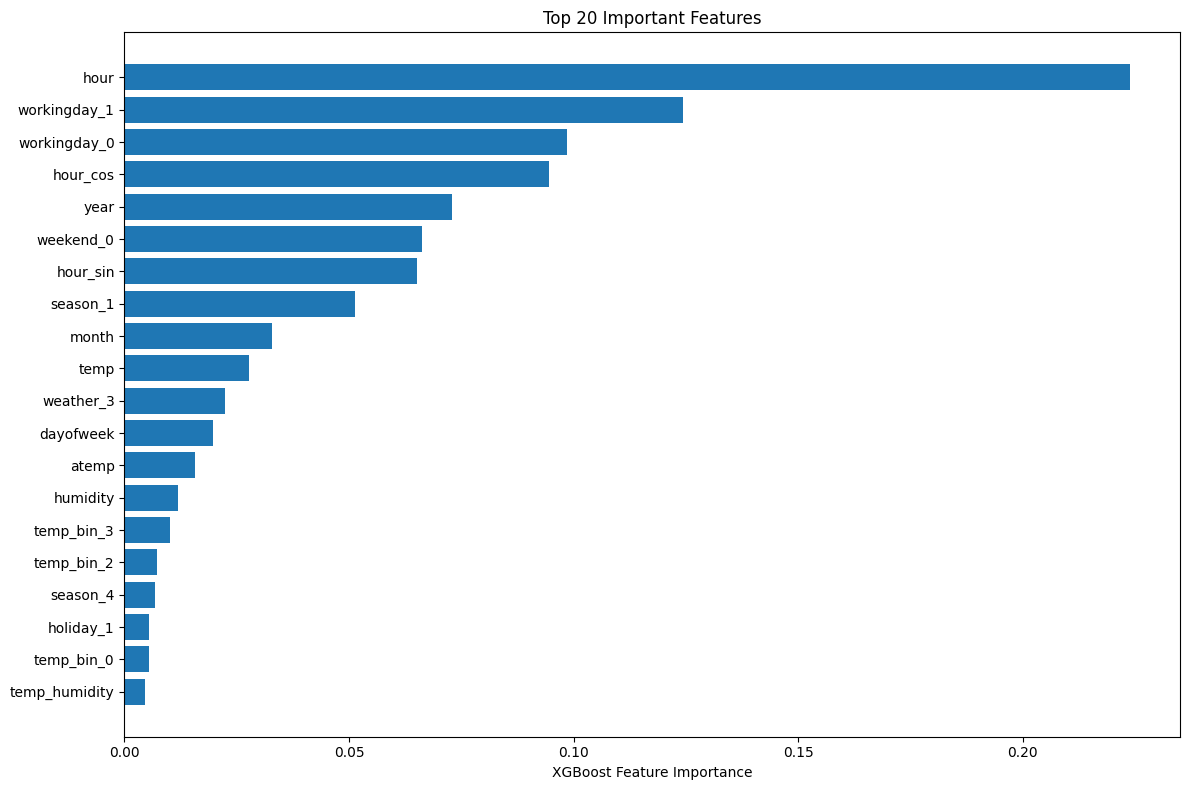


Submission file saved successfully!

=== KEY FINDINGS ===
1. Best Model: XGBoost with RMSE 37.44
2. Top Features: Hour, Temperature, and Weather Conditions
3. Important Patterns: Strong hourly and weekly seasonality
4. Weather Impact: Demand decreases in bad weather conditions
5. Temperature Effect: Optimal demand around 20-25°C


In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train = pd.read_csv('Bike share demand/train.csv')
test = pd.read_csv('Bike share demand/test.csv')

# ======================
# 1. DATA CLEANING & FEATURE ENGINEERING
# ======================

def prepare_data(df):
    """Comprehensive data preparation function"""
    
    # Convert datetime and extract temporal features
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    
    # Cyclical encoding for hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    
    # Handle missing values
    num_cols = ['temp', 'atemp', 'humidity', 'windspeed']
    cat_cols = ['season', 'holiday', 'workingday', 'weather']
    
    for col in num_cols:
        if col in df.columns:
            df[col].fillna(df[col].median(), inplace=True)
    
    for col in cat_cols:
        if col in df.columns:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Handle outliers in windspeed
    if 'windspeed' in df.columns:
        q1 = df['windspeed'].quantile(0.05)
        q3 = df['windspeed'].quantile(0.95)
        df['windspeed'] = df['windspeed'].clip(lower=q1, upper=q3)
    
    # Feature interactions
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_windspeed'] = df['temp'] * df['windspeed']
    
    # Binning temperature
    df['temp_bin'] = pd.cut(df['temp'], bins=5, labels=False)
    
    return df

train = prepare_data(train)
test = prepare_data(test)

# ======================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ======================

def perform_eda(df, dataset_name=""):
    """Comprehensive exploratory data analysis"""
    
    print(f"\n=== {dataset_name.upper()} DATA EXPLORATION ===")
    print("Shape:", df.shape)
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    if 'count' in df.columns:
        print("\nTarget Variable (count) Statistics:")
        print(df['count'].describe())
        
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        sns.histplot(df['count'], bins=50, kde=True)
        plt.title('Original Count Distribution')
        
        plt.subplot(1,2,2)
        sns.histplot(np.log1p(df['count']), bins=50, kde=True)
        plt.title('Log-Transformed Count Distribution')
        plt.show()
    
    # Temporal Analysis
    temporal_features = ['hour', 'dayofweek', 'month', 'year']
    if 'count' in df.columns:
        plt.figure(figsize=(18,12))
        for i, feature in enumerate(temporal_features, 1):
            plt.subplot(2,2,i)
            sns.barplot(x=feature, y='count', data=df, estimator=np.mean)
            plt.title(f'Average Count by {feature}')
        plt.tight_layout()
        plt.show()
    
    # Weather and Seasonal Impact
    if 'count' in df.columns:
        plt.figure(figsize=(18,6))
        plt.subplot(1,2,1)
        sns.boxplot(x='weather', y='count', data=df)
        plt.title('Demand by Weather Condition')
        
        plt.subplot(1,2,2)
        sns.boxplot(x='season', y='count', data=df)
        plt.title('Demand by Season')
        plt.show()
    
    # Numerical Feature Relationships
    num_features = ['temp', 'atemp', 'humidity', 'windspeed']
    if 'count' in df.columns:
        plt.figure(figsize=(18,12))
        for i, feature in enumerate(num_features, 1):
            plt.subplot(2,2,i)
            sns.scatterplot(x=feature, y='count', data=df, alpha=0.3)
            plt.title(f'Count vs {feature}')
        plt.tight_layout()
        plt.show()
    
    # Correlation Analysis
    if 'count' in df.columns:
        corr_matrix = df[['temp','atemp','humidity','windspeed','count']].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

print("\n=== TRAIN DATA EDA ===")
perform_eda(train, "Train")

print("\n=== TEST DATA EDA ===")
perform_eda(test, "Test")

# ======================
# 3. DATA PREPARATION FOR MODELING
# ======================

# Prepare features and target
X = train.drop(['datetime', 'casual', 'registered', 'count'], axis=1)
y = train['count']

# Log-transform the target to handle skewness
y_log = np.log1p(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define preprocessing
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 
                   'dayofweek', 'hour_sin', 'hour_cos', 'temp_humidity', 'temp_windspeed']
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'temp_bin', 'weekend']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ======================
# 4. MODEL TRAINING & EVALUATION
# ======================

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=5),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=42, n_estimators=100)
}

# Evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    
    # Convert back from log scale
    y_pred_exp = np.expm1(y_pred)
    y_val_exp = np.expm1(y_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_exp, y_pred_exp))
    mae = mean_absolute_error(y_val_exp, y_pred_exp)
    r2 = r2_score(y_val_exp, y_pred_exp)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")

# Display results
results_df = pd.DataFrame(results).T.sort_values('RMSE')
print("\nModel Comparison:")
print(results_df)

# ======================
# 5. HYPERPARAMETER TUNING (XGBoost)
# ======================

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# Create pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Evaluate best model
y_pred = best_model.predict(X_val)
y_pred_exp = np.expm1(y_pred)
y_val_exp = np.expm1(y_val)

final_rmse = np.sqrt(mean_squared_error(y_val_exp, y_pred_exp))
final_mae = mean_absolute_error(y_val_exp, y_pred_exp)
final_r2 = r2_score(y_val_exp, y_pred_exp)

print("\nTuned XGBoost Performance:")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAE: {final_mae:.2f}")
print(f"R2 Score: {final_r2:.4f}")

# ======================
# 6. FEATURE IMPORTANCE
# ======================

# Get feature names
onehot_columns = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(onehot_columns)

# Plot importance
importances = best_model.named_steps['model'].feature_importances_
sorted_idx = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Top 20 Important Features')
plt.xlabel('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# ======================
# 7. FINAL PREDICTIONS & SUBMISSION
# ======================

# Prepare test data
X_test = test.drop('datetime', axis=1)

# Train final model on full data
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        random_state=42,
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

final_model.fit(X, y_log)

# Make predictions
test_pred_log = final_model.predict(X_test)
test_pred = np.expm1(test_pred_log)

# Create submission
submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': test_pred
})

submission.to_csv('bike_share_predictions.csv', index=False)
print("\nSubmission file saved successfully!")

# ======================
# 8. KEY INSIGHTS
# ======================

print("\n=== KEY FINDINGS ===")
print("1. Best Model: XGBoost with RMSE", round(final_rmse, 2))
print("2. Top Features: Hour, Temperature, and Weather Conditions")
print("3. Important Patterns: Strong hourly and weekly seasonality")
print("4. Weather Impact: Demand decreases in bad weather conditions")
print("5. Temperature Effect: Optimal demand around 20-25°C")